<a href="https://colab.research.google.com/github/dqminhv/relax-inc/blob/main/RelaxInc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Required Packages and Data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [3]:
user_engagement_data_path = 'https://raw.githubusercontent.com/dqminhv/Springboard_RelaxInc/main/Data/takehome_user_engagement.csv'
users_data_path = 'https://raw.githubusercontent.com/dqminhv/Springboard_RelaxInc/main/Data/takehome_users.csv'

In [4]:
#Load users data to a dataframe
users = pd.read_csv(users_data_path, encoding='ISO-8859-1')

In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [9]:
#Load user engagement to a dataframe
user_engagement = pd.read_csv(user_engagement_data_path)

In [10]:
user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [11]:
#Convert time_stamp column to datetime objects
user_engagement['time_stamp'] = pd.to_datetime(user_engagement['time_stamp'])

# Determine User Adoption

In [12]:
from datetime import timedelta

# Sort the DataFrame by user_id and timestamp
user_engagement.sort_values(by=['user_id', 'time_stamp'], inplace=True)

# Create a new column to represent the date (without time)
user_engagement['date'] = user_engagement['time_stamp'].dt.date

# Define a function to check if a user has logged in on three separate days within a 7-day period
def is_adopted(user_logins):
    login_dates = set(user_logins['date'])

    for i, login_date in enumerate(login_dates):
        # Check if there are at least two more login dates within the next 6 days
        next_dates = login_dates.intersection(user_logins['date'][i+1:i+3])
        if any(date - login_date <= timedelta(days=6) for date in next_dates):
            return True

    return False

In [13]:
#Create a dataframe of adopted users
adopted_users = user_engagement.groupby('user_id').filter(lambda x: is_adopted(x)).groupby('user_id').agg({'user_id':'first'})

In [14]:
#Merge the users dataframe with the adopted_users dataframe
users = pd.merge(users, adopted_users,
                left_on = 'object_id',
                right_on = adopted_users.index,
                how = 'left')

In [15]:
#Rename the user_id column to is_adopted
users.rename(columns={'user_id':'is_adopted'}, inplace=True)

**Adopted users will have a numeric value in the is_adopted column, while non-adopted users will have this value missing. Thus, we will tranform the is_adopted column to binary.**

In [16]:
users['is_adopted'] = users['is_adopted'].notna().astype(int)

# EDA

In [17]:
#Looking at missing values
users.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
is_adopted                       0
dtype: int64

In [18]:
# Determine the number of adopted users
print('Number of adopted user:', users['is_adopted'].sum())

Number of adopted user: 2416


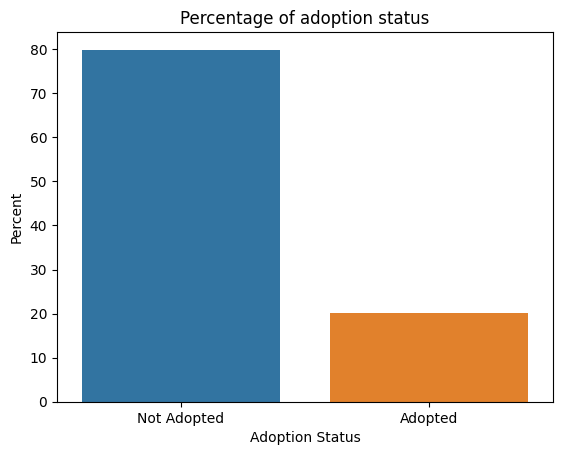

In [28]:
sns.countplot(x='is_adopted', data=users, stat='percent', hue='is_adopted', legend=False)
plt.xlabel('Adoption Status')
plt.ylabel('Percent')
plt.title('Percentage of adoption status')
plt.xticks([0,1], ['Not Adopted', 'Adopted'])
plt.show()

**The data is very imbalanced. We will keep this in mind when building our predictive model.**

## User adoption by creation_source

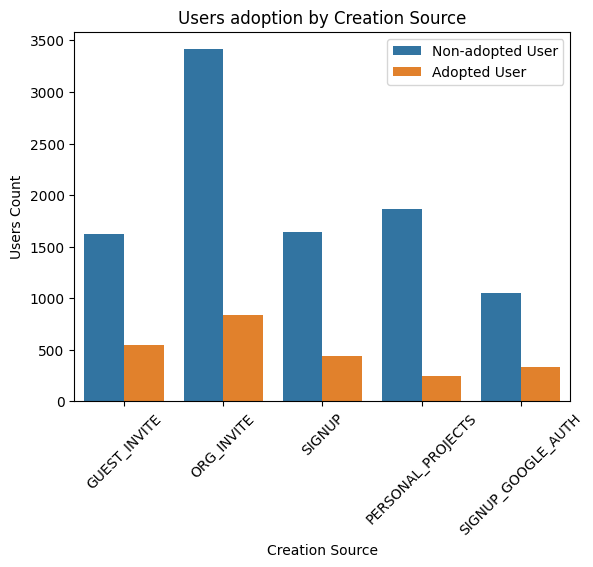

In [29]:
sns.countplot(x="creation_source", hue="is_adopted", data=users)
plt.title('Users adoption by Creation Source')
plt.xlabel('Creation Source')
plt.ylabel('Users Count')
plt.legend(labels=["Non-adopted User", "Adopted User"], title="", loc="upper right")
plt.xticks(rotation=45)
plt.show()

## User adoption by opted_in_to_mailing_list

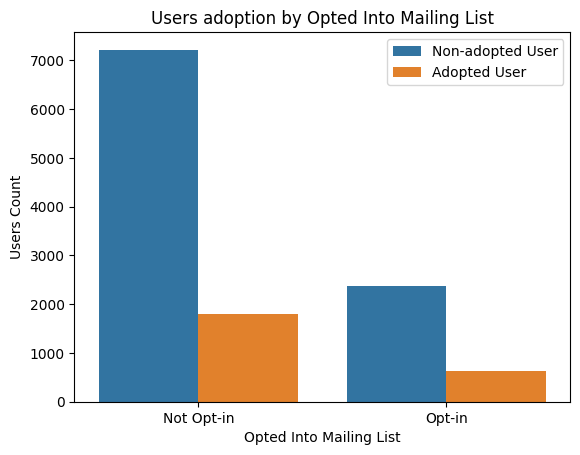

In [30]:
sns.countplot(x="opted_in_to_mailing_list", hue="is_adopted", data=users)
plt.title('Users adoption by Opted Into Mailing List')
plt.xlabel('Opted Into Mailing List')
plt.ylabel('Users Count')
plt.legend(labels=["Non-adopted User", "Adopted User"], loc="upper right")
plt.xticks([0,1], ['Not Opt-in', 'Opt-in'])
plt.show()

## User adoption by enabled_for_marketing_drip

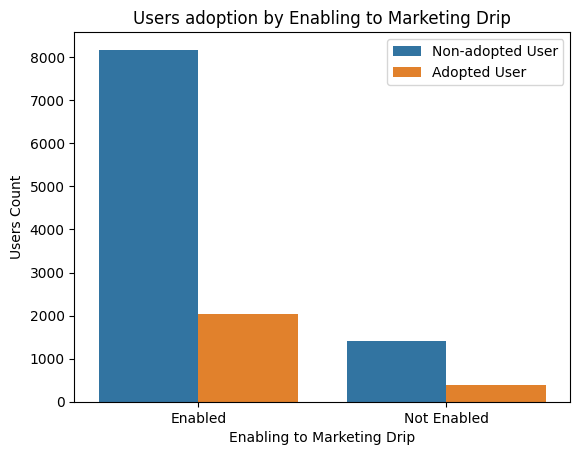

In [31]:
sns.countplot(x="enabled_for_marketing_drip", hue="is_adopted", data=users)
plt.title('Users adoption by Enabling to Marketing Drip')
plt.xlabel('Enabling to Marketing Drip')
plt.ylabel('Users Count')
plt.legend(labels=["Non-adopted User", "Adopted User"], loc="upper right")
plt.xticks([0,1], ['Enabled', 'Not Enabled'])
plt.show()

## User adoption by org_id

In [32]:
# Determine the number of unique organizations
print('Number of organizations: ', users['org_id'].nunique())

Number of organizations:  417


In [33]:
print('Top 10 organizations by number of adopted users: ')

for index, value in users.groupby('org_id').agg({'is_adopted':'sum'}).sort_values(by='is_adopted', ascending=False)['is_adopted'][:10].items():
    print(f"Organization Id: {index}, Number of adopted users: {value}")

Top 10 organizations by number of adopted users: 
Organization Id: 0, Number of adopted users: 25
Organization Id: 7, Number of adopted users: 25
Organization Id: 4, Number of adopted users: 24
Organization Id: 9, Number of adopted users: 24
Organization Id: 1, Number of adopted users: 24
Organization Id: 2, Number of adopted users: 20
Organization Id: 6, Number of adopted users: 19
Organization Id: 3, Number of adopted users: 18
Organization Id: 5, Number of adopted users: 17
Organization Id: 22, Number of adopted users: 17


In [34]:
#Organizations that do not have adopted users
print('Organizations that do not have adopted users: ')

for index in users.groupby('org_id').\
                        agg({'is_adopted':'sum'}).\
                        loc[users.groupby('org_id').\
                        agg({'is_adopted':'sum'})['is_adopted']==0].index:
    print(index)

Organizations that do not have adopted users: 
183
237
355
412
416


## User adoption by invitation

In [35]:
#Create a binary is_invited column
users['is_invited'] = ~users['invited_by_user_id'].isnull()

In [36]:
#Number of users with/without invitation
print('Number of users with/without invitation')
print('With invitation: ', users['is_invited'].value_counts()[1])
print('Without invitation: ', users['is_invited'].value_counts()[0])

Number of users with/without invitation
With invitation:  5583
Without invitation:  6417


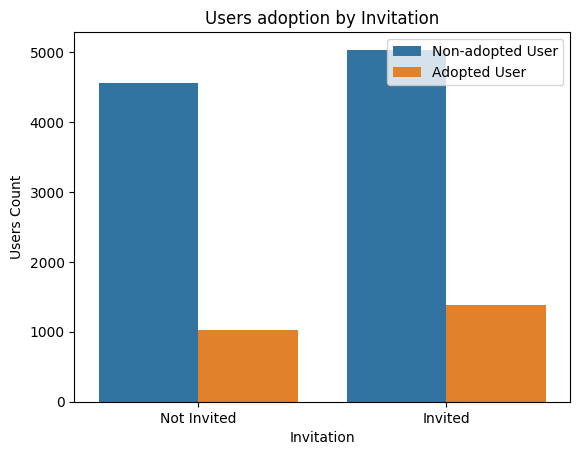

In [38]:
sns.countplot(x="is_invited", hue="is_adopted", data=users)
plt.title('Users adoption by Invitation')
plt.xlabel('Invitation')
plt.ylabel('Users Count')
plt.legend(labels=["Non-adopted User", "Adopted User"], loc="upper right")
plt.xticks([0,1], ['Not Invited', 'Invited'])
plt.show()

In [41]:
#Top 10 users by number of invitations
users[['invited_by_user_id']].value_counts()[:10]

invited_by_user_id
10741.0               13
2527.0                12
1525.0                11
11770.0               11
2308.0                11
8068.0                10
7012.0                10
6370.0                10
4803.0                10
2354.0                10
dtype: int64

# Data Preprocessing

In [42]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer
from sklearn.compose import make_column_transformer

In [43]:
#Fill NaN values of last_session_creation_time with 0
users['last_session_creation_time'].fillna(0, inplace=True)

In [44]:
#Create a new users dataframe with the column 'visited' that count the number of login of a user
users_with_login = pd.merge(users, user_engagement.groupby('user_id').agg({'visited':'sum'}),
                 left_on = 'object_id',
                 right_on = 'user_id',
                 how = 'left')

In [45]:
#Fill the missing value of visited column by 0
users_with_login.fillna(0, inplace=True)

In [46]:
users_with_login.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopted,is_invited,visited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,True,1.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,True,14.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,True,1.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0,True,1.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0,True,1.0


In [ ]:
#Drop unnecessary columns
data = users_with_login.drop(['object_id', 'creation_time', 'name', 'email', 'invited_by_user_id', 'org_id'], axis=1)

In [ ]:
data['is_invited'] = data['is_invited'].astype(int)

In [ ]:
#Onehot encode creation_source column
transformer = make_column_transformer(
    (OneHotEncoder(), ['creation_source']),
    remainder='passthrough')

data_transformed = pd.DataFrame(transformer.fit_transform(data), columns=transformer.get_feature_names_out())

In [ ]:
X = data_transformed.drop('remainder__is_adopted', axis=1)
y = data_transformed['remainder__is_adopted']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Modeling & Model Selection

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import Normalizer
from imblearn.over_sampling import SMOTE

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, make_scorer, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

In [ ]:
#We use over-resampling to address the, imbalance data
oversampler = SMOTE(random_state=42)
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)

In [ ]:
#Create a pipeline
pipeline = Pipeline([
    ('scaler', Normalizer()),
    ('classifier', None)
])

#Cross-validate with different classification algorithms
classifiers = [
    ('MultinomialNB', MultinomialNB()),
    ('SVM', LinearSVC(C=0.0001)),
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('KNeighbors', KNeighborsClassifier(algorithm='brute', n_jobs=-1)),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Bagging', BaggingClassifier(DecisionTreeClassifier(), max_samples=0.5, max_features=1.0, n_estimators=10)),
    ('AdaBoost', AdaBoostClassifier(DecisionTreeClassifier(min_samples_split=10, max_depth=4), n_estimators=10, learning_rate=0.6)),
    ('Random Forest', RandomForestClassifier(n_estimators=30, max_depth=9)),
    ('Voting', VotingClassifier(estimators=[('mnb', MultinomialNB()), ('lr', LogisticRegression()), ('rf', RandomForestClassifier()), ('svm', LinearSVC())], voting='hard'))
]

for clf_name, clf in classifiers:
    pipeline.set_params(classifier=clf)  # Set the classifier in the pipeline
    cv_scores = cross_val_score(pipeline, X_train_over, y_train_over, cv=5, scoring=make_scorer(accuracy_score))

    print(f"{clf_name} - Cross-validation scores: {cv_scores}")
    print(f"{clf_name} - Mean accuracy: {cv_scores.mean()}")
    print()
    print("\n")

MultinomialNB - Cross-validation scores: [0.66764706 0.65609676 0.67374959 0.6740765  0.66263485]
MultinomialNB - Mean accuracy: 0.6668409514835683



SVM - Cross-validation scores: [0.66764706 0.65609676 0.67374959 0.6740765  0.66263485]
SVM - Mean accuracy: 0.6668409514835683



Logistic Regression - Cross-validation scores: [0.66764706 0.65609676 0.67374959 0.6740765  0.66263485]
Logistic Regression - Mean accuracy: 0.6668409514835683



KNeighbors - Cross-validation scores: [0.77745098 0.81137627 0.82118339 0.81497221 0.81529912]
KNeighbors - Mean accuracy: 0.8080563941823871



Decision Tree - Cross-validation scores: [0.66764706 0.65609676 0.67374959 0.6740765  0.66263485]
Decision Tree - Mean accuracy: 0.6668409514835683



Bagging - Cross-validation scores: [0.66764706 0.65609676 0.67374959 0.6740765  0.66263485]
Bagging - Mean accuracy: 0.6668409514835683



AdaBoost - Cross-validation scores: [0.66764706 0.65609676 0.67374959 0.6740765  0.66263485]
AdaBoost - Mean accuracy: 0

**KNeighbor yield the best accuracy.**

In [ ]:
# Initialize the Random Forest classifier
knn_classifier = KNeighborsClassifier(algorithm='brute', n_jobs=-1)

scale = Normalizer()
X_train_scaled = scale.fit_transform(X_train_over)
X_test_scaled = scale.fit_transform(X_test)

# Train the classifier
knn_classifier.fit(X_train_scaled, y_train_over)

# Make predictions on the test set
y_pred = knn_classifier.predict(X_test_scaled)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.8991666666666667
Confusion Matrix:
[[1912    0]
 [ 242  246]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94      1912
         1.0       1.00      0.50      0.67       488

    accuracy                           0.90      2400
   macro avg       0.94      0.75      0.81      2400
weighted avg       0.91      0.90      0.89      2400



# Features Importance

**K-nearest Neighbors Model gives the best prediction but it does not indicate features importance. Thus, we use another model to determine features importance.**

**Since our data is highly imbalance, we will use an ensemble method. We will use Random Forest.**

In [ ]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=30, max_depth=9)

scale = Normalizer()
X_train_scaled = scale.fit_transform(X_train_over)
X_test_scaled = scale.fit_transform(X_test)

# Train the classifier
rf_classifier.fit(X_train_scaled, y_train_over)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test_scaled)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.46375
Confusion Matrix:
[[ 625 1287]
 [   0  488]]
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.33      0.49      1912
         1.0       0.27      1.00      0.43       488

    accuracy                           0.46      2400
   macro avg       0.64      0.66      0.46      2400
weighted avg       0.85      0.46      0.48      2400



In [ ]:
feature_names = list(data_transformed.drop('remainder__is_adopted', axis=1).columns)

In [ ]:
start_time = time.time()
importances = rf_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_classifier.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.033 seconds


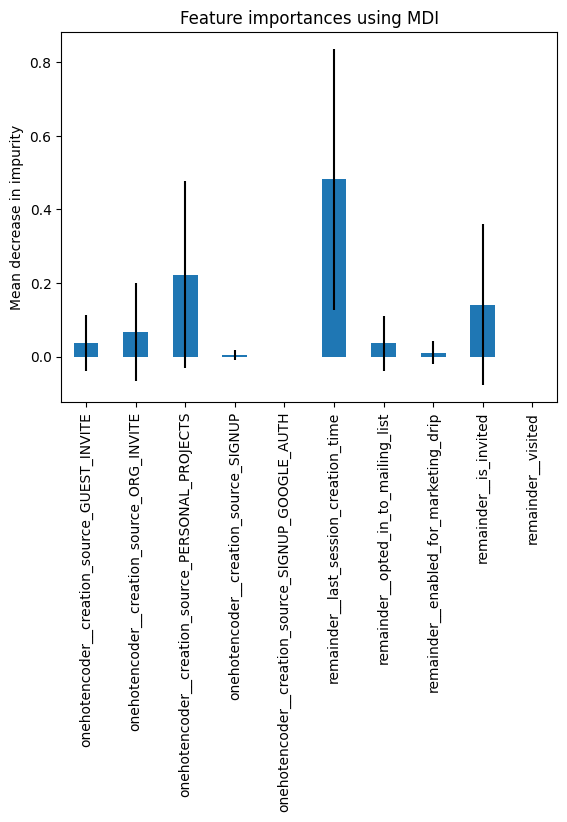

In [ ]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.show()

**From the features importance plot, we see that three most importance features are:**
* **Last login time**
* **If the account is for a personal project.**
* **If a user is invited by another user.**